# AWQ (activation aware weight only quantization)

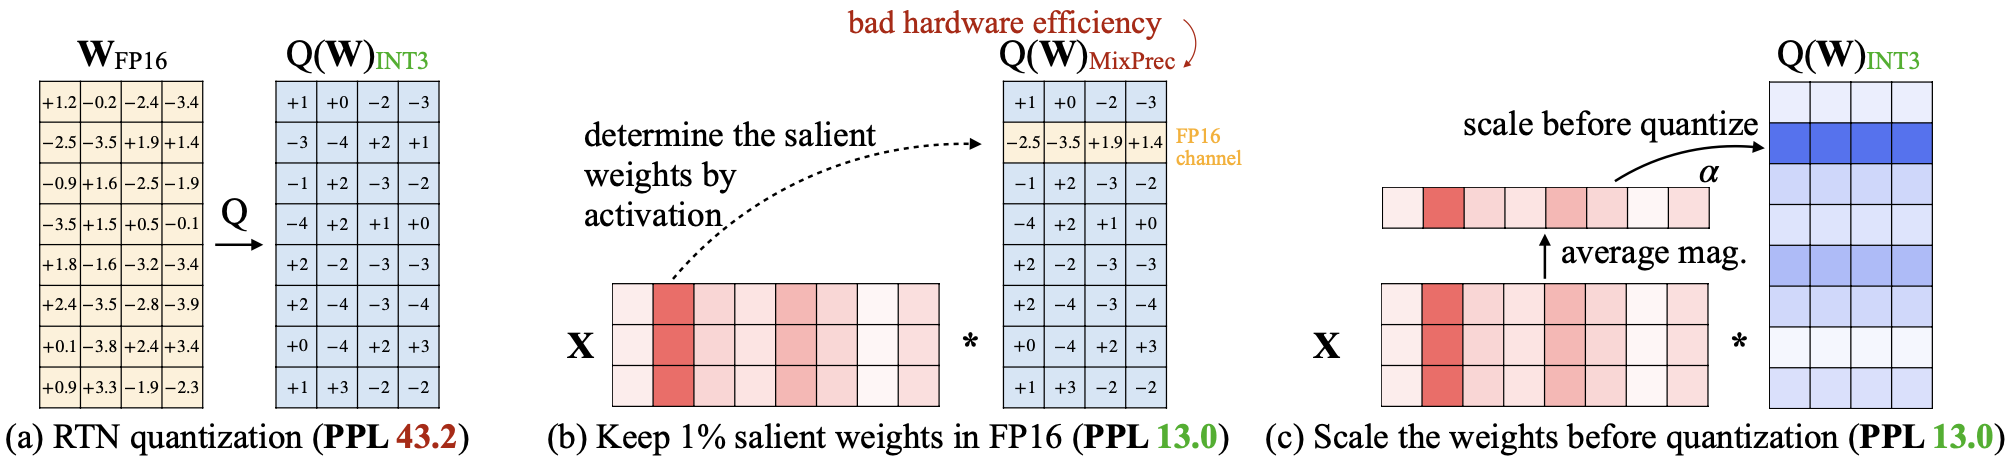

Large language models (LLMs) have shown excellent performance on various tasks, but the astronomical model size raises the hardware barrier for serving (memory size) and slows down token generation (memory bandwidth). LLM sizes and computation are increasing exponentially, while memory bandwidth is increasing slowly. This gap is a major bottleneck for LLMs. In this lab, we will explore the use of an novel quantization algorithm (AWQ) to reduce memory footprint of LLMs and achieve accelerations for inference.

For the LLaMA-65B model, in the decoding stage of single batch inference, we need to perform GEMV $[1, 8192] \times [8192, 8192]$. Taking the NVIDIA A100 80G as an example, its half-precision (FP16) performance is 312TFLOPS, and the memory bandwidth is about 2000GB/s. Therefore, its computation intensity is:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

This is very memory-bounded (~$10^2$ gap), which is why we need low-bit weight quantization.

In [1]:
# print('Installing packages...')
# !pip install torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 datasets==2.14.4 tqdm zstandard

In [2]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc

Here we use wikitext-2 dataset for evaluation. The dataset is automatically downloaded by the code.

In [3]:
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))


In [4]:
def get_model_size(model: nn.Module, data_width=16, group_size=-1):

    if group_size != -1:
        data_width += (16 + 4) / group_size

    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Let's first evaluate the perplexity and model size of the FP32 Model.

In [5]:
model_path = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=32, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

/home/sathya/anaconda3/envs/awq/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/sathya/anaconda3/envs/awq/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
evaluating...: 100%|██████████| 40/40 [00:11<00:00,  3.51it/s]


model perplexity: 14.47
model size: 5043.73 MiB


Uniform quantization is to map real values in the range $[\beta, \alpha]$ to lie within $[0, 2^{b} - 1]$.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$
\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}
\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}
\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



### pseudo quantization
The following code is for pseudo quantization.

Pseudo Quantization is used to simulate the effects of quantization on a model  without actually quantizing the model's weights. (i.e. rounding to the nearest quantized value and then **dequantizing back to a float**.)

In [6]:
import ipdb
# core quantization method (simulated quantization)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    org_w_shape = w.shape
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    max_val = w.amax(dim=1, keepdim=True) if (w.dim() == 2)  else w.amax(dim=1, keepdim=False).unsqueeze(1)
    min_val = w.amin(dim=1, keepdim=True) if (w.dim() == 2) else w.amax(dim=1, keepdim=False).unsqueeze(1)

    # Calculate the scale factor and zero point.  (Formula 1 & 2)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)

    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # Quantize W: Map values in the range [\beta, \alpha] to lie within [0, 2^b - 1] (Formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)
    # Dequantize W (pseudo quantization, the inverse transformation of Formula 3)
    w = (w - zeros) * scales

    assert torch.isnan(w).sum() == 0

    w = w.reshape(org_w_shape)
    return w

@torch.no_grad()
def pseudo_quantize_model_weight(
    model, w_bit, q_group_size,
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

There is a observation in LLM activations that **outliers appear in a small fraction of the channels**. If one channel has an outlier, it **persistently appears in all tokens**. The variance amongst the channels for a given token is large (the activations in some channels are very large, but most are small), but the variance between the magnitudes of a given channel across tokens is small (outlier channels are consistently large).

According to the observation of AWQ, weight channels corresponding to activation outliers are more salient, and preserving those salient weights can lead to a significant performance improvement. Next, let's try to find the salient weights and retain them as original values to observe the change in perplexity.

The following code is used to load the calibration dataset, so as to obtain activation outliers to identify salient weights.

In [7]:
def get_calib_dataset(tokenizer=None, n_samples=256, block_size=512):
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > block_size:
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break

    # now concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]

@torch.no_grad()
def get_calib_feat(model, tokenizer):
    input_dict = dict()
    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()
        if name not in input_dict:
            input_dict[name] = [x_max]
        else:
            input_dict[name] += [x_max]

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook, name=name)))

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    samples = get_calib_dataset(tokenizer)
    pbar = tqdm.tqdm(samples)
    for input_ids in pbar:
        input_ids = input_ids.to(device)
        model(input_ids)

    for hook in hooks:
        hook.remove()
    return input_dict

In [8]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
input_feat = get_calib_feat(model, tokenizer)

/home/sathya/anaconda3/envs/awq/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


 * Split into 127 blocks


100%|██████████| 127/127 [00:07<00:00, 16.21it/s]


According to the methodology of AWQ, simply scaling up the salient weight channels can protect them. The principle is as follows:

- Consider a linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$). We care about the quantization error from $Q(\mathbf{w})x$.

- $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.
- The scaled version is $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- The $RoundErr$ is always ~0.25 (average from 0-0.5).
- When the group size is relatively large (e.g., 128), scaling up one channel usually does not increase the maximum value in a group (i.e. $Δ$ remains unchanged).
- Thus, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

Taking the following figure as an example, if we assume 3-bit int quantization, then the quantization error caused by the value in the last column of the second row of $W(+1.4)$ should be $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$ = $\frac{4}{2^{3 - 1}} * |1.4 - 1.0| * (2 + 2 + 2) = 2.4$.

If the second channel is scaled up by a factor of $2$, the resulting quantization error would reduce to $\frac{4}{2^{3 - 1}} * |2.8 - 3.0| * (2/2 + 2/2 + 2/2) = 0.6$.

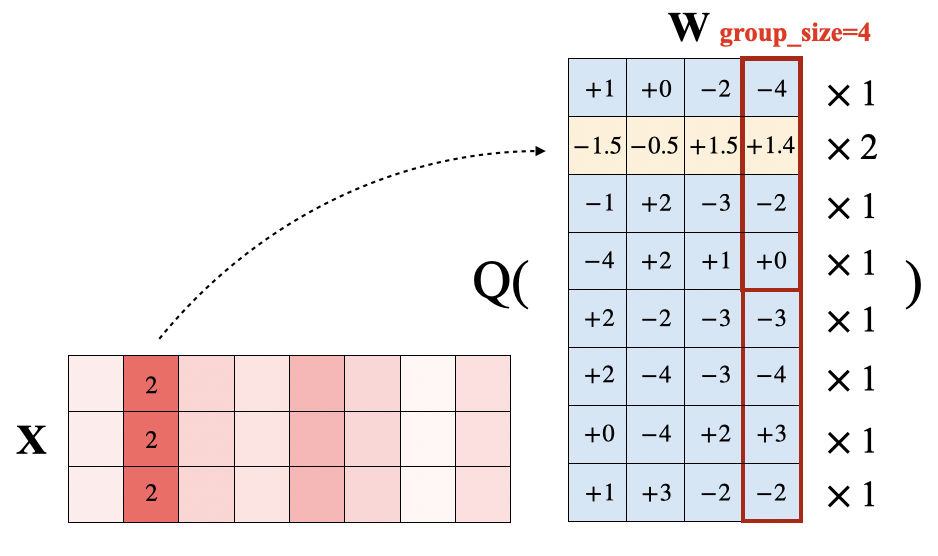

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha}
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [9]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):
    if not isinstance(fcs, list):
        fcs = [fcs]

    scales = scales.to(ln.weight.device)

    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)

    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))

    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0

@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)
    
    scales = scales.to(fc1.weight.device)

    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))

    fc2.weight.mul_(scales.view(1, -1))

    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0

@torch.no_grad()
def scale_conv_conv(conv1, conv2, scales):
    assert isinstance(conv1, nn.Conv2d)
    assert isinstance(conv2, nn.Conv2d)
    
    scales = scales.to(conv1.weight.device)

    conv1.weight.div_(scales.view(-1, 1,1,1))
    if conv1.bias is not None:
        conv1.bias.div_(scales.view(-1))

    conv2.weight.mul_(scales.view(1, -1,1,1))

    for p in conv1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in conv2.parameters():
        assert torch.isnan(p).sum() == 0

@torch.no_grad()
def scale_conv_conv(conv1, fc1, scales):
    assert isinstance(conv1, nn.Conv2d)
    assert isinstance(fc1, nn.Linear)
    
    scales = scales.to(conv1.weight.device)

    conv1.weight.div_(scales.view(-1, 1,1,1))
    if conv1.bias is not None:
        conv1.bias.div_(scales.view(-1))

    fc1.weight.mul_(scales.view(1, -1))

    for p in conv1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0


@torch.no_grad()
def auto_scale_block(module, name, w_bit,
                     q_group_size,
                     input_feat):

    # find the best scale ratio
    def _search_module_scale(block, linears2scale: list, x, kwargs={}):

        x = x.to(next(block.parameters()).device)
        with torch.no_grad():
            org_out = block(x, **kwargs)
            if isinstance(org_out, tuple):
                org_out = org_out[0]

        s_x = x.view(-1, x.shape[-1]).abs().mean(0)

        # Initialize the best_error, best_ratio and best_scales
        best_error = torch.inf
        best_ratio = -1
        best_scales = 0

        n_grid = 20
        history = []

        org_sd = {k: v.cpu() for k, v in block.state_dict().items()}
        for ratio in range(n_grid):
            # ratio is the \alpha in the formula
            ratio = ratio * 1 / n_grid
            # Calculate the scales by the formula: scales = s_x^ratio
            scales = torch.clamp(s_x, 1e-5) ** ratio # must clip the s_x, otherwise will get nan later
            assert scales.shape == s_x.shape
            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)

            for fc in linears2scale:
                scales = scales.to(fc.weight.device)
                # Scale up the values of the weight channels
                fc.weight.mul_(scales)
                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)
                # Scale back down the values of the weight channels
                fc.weight.data /= scales

            out = block(x, **kwargs)
            if isinstance(out, tuple):
                out = out[0]

            loss = (org_out - out).float().pow(2).mean().item()  # float prevents overflow
            history.append(loss)
            is_best = loss < best_error
            if is_best:
                best_error = loss
                best_ratio = ratio
                best_scales = scales
            block.load_state_dict(org_sd)

        if best_ratio == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)

        assert torch.isnan(best_scales).sum() == 0, best_scales
        return best_scales.detach()

    # attention input
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # attn out
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # fc1
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # fc2
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

@torch.no_grad()
def pseudo_quantize_model_weight_auto_scale(
    model, w_bit, q_group_size, input_feat
):
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)

    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

In [10]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_auto_scale(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\n Quantized Model Perplexity: {model_perplexity:.2f}")
print(f"Quantized Model Size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


 Quantized Model Perplexity: 17.93
Quantized Model Size: 495.06 MiB


In [11]:
original_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

# Evaluate the model
model_perplexity = evaluate(original_model, tokenizer)
model_size = get_model_size(original_model, data_width=32, group_size=128)
print(f"\n Original Model Perplexity: {model_perplexity:.2f}")
print(f"Original Model Size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


 Original Model Perplexity: 14.47
Original Model Size: 5043.73 MiB
